## ANOMALÍAS EN EQUIPOS INDUSTRIALES

ABSTRACT

Dentro de una industria es esencial realizar seguimiento de las variables. No solo de las que tienen incidencia en resultados financieros sino también en el desempeño de la producción. El área de de mantenimiento realiza mediciones recurrentes para evitar futuros prejuicios de los equipamentos e instalaciones y asi no comprometer la seguridad de los mismos y de las personas dentro del establecimiento.

El siguiente dataset ,obtenido desde la página de Kaggle, muestra un registro de variables fisicas (Presión, temperatura, vibración y humedad) en compresores, bombas y turbinas. Los equipos están ubicados en diferentes locaciones dentro de Estados Unidos.

El análisis se puede hacer extensivo para el todos los equipos industriales del dataset solo que, en este caso se buscará validar la incidencia de las variables físicas sobre la probabilidad de falla en turbinas.


HIPÓTESIS

Se buscará encontrar una relación entre las variables físicas y las veces que ocurrieron fallas en los equipos. 
Se comprobará si alguna de las variables tiene más incidencia en los eventos de fallas. Como por ejemplo, si valores altos de presión son la principal causa de fallas en bombas. O si una alta temperatura lo es para los compresores. Posteriormente, se desarrollará un modelo de predicción para saber si fallará o no frente a determinados valores de condiciones físicas.

### ANÁLISIS DE DATASET

Se realiza un análisis exploratorio para saber cómo está conformado el dataset, seguido de un análisis estadístico donde se podrá detectar las primeras conclusiones.

In [1]:
import pandas as pd

# Cargar el archivo CSV principal
df = pd.read_csv("equipment_anomaly_data.csv")
print(df.head())

print(df.info())


   temperature   pressure  vibration   humidity   equipment       location  \
0    58.180180  25.029278   0.606516  45.694907     Turbine        Atlanta   
1    75.740712  22.954018   2.338095  41.867407  Compressor        Chicago   
2    71.358594  27.276830   1.389198  58.954409     Turbine  San Francisco   
3    71.616985  32.242921   1.770690  40.565138        Pump        Atlanta   
4    66.506832  45.197471   0.345398  43.253795        Pump       New York   

   faulty  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7672 entries, 0 to 7671
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  7672 non-null   float64
 1   pressure     7672 non-null   float64
 2   vibration    7672 non-null   float64
 3   humidity     7672 non-null   float64
 4   equipment    7672 non-null   object 
 5   location     7672 non-null   object 
 6   faulty      

ANÁLISIS ESTADÍSTICO

In [2]:
df_turbina = df[df['equipment'] == 'Turbine']
df_turbina.describe()

,temperature,pressure,vibration,humidity,faulty
count,2565.000000,2565.000000,2565.000000,2565.000000,2565.000000
mean,70.645348,35.855169,1.614488,49.675695,0.100585
std,16.251521,10.278006,0.741606,11.843054,0.300837
min,11.220335,5.165296,-0.428188,10.719373,0.000000
25%,62.465821,29.616814,1.174148,42.325967,0.000000
50%,69.758044,35.373099,1.528688,49.787272,0.000000
75%,77.158727,41.191017,1.924403,56.960423,0.000000
max,149.480406,79.887734,4.990537,89.984718,1.000000


In [3]:
# Crear lista de columnas de tabla informativa
columnas_tabla = [col for col in df_turbina.columns ]

# Crear un resumen con tipo de dato y cantidad de valores nulos
resumen = pd.DataFrame({
    'Tipo de dato': df_turbina[columnas_tabla].dtypes,
    'Valores nulos': df_turbina[columnas_tabla].isnull().sum(),
    'Porcentaje nulos (%)': df_turbina[columnas_tabla].isnull().mean() * 100
})

print(resumen)



            Tipo de dato  Valores nulos  Porcentaje nulos (%)
temperature      float64              0                   0.0
pressure         float64              0                   0.0
vibration        float64              0                   0.0
humidity         float64              0                   0.0
equipment         object              0                   0.0
location          object              0                   0.0
faulty           float64              0                   0.0


Según nos muestra este análisis, nuestras columnas no contienen valores nulos (NaN) . Adicionalmente nos muestra el tipo de datos con el que contamos en cada una de ellas.

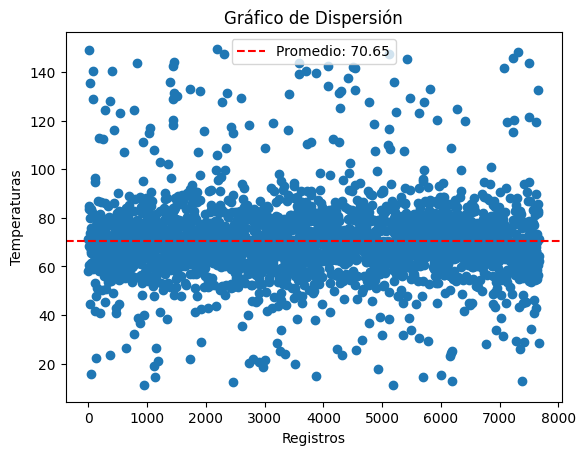

In [4]:
import matplotlib.pyplot as plt 
import numpy as np


x = df_turbina.index
y = df_turbina['temperature']
promedio_tempe= y.mean()

plt.scatter(x, y) 
plt.title('Gráfico de Dispersión') 
plt.xlabel('Registros') 
plt.axhline(promedio_tempe, color='red', linestyle='--', label=f'Promedio: {promedio_tempe:.2f}')
plt.ylabel('Temperaturas') 
plt.legend()
plt.show()

### DETECCIÓN Y FILTRADO DE OUTLIERS

C:\Users\victoria.palma\AppData\Local\Temp\ipykernel_25016\3601368039.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='equipment', y='temperature', data=df_turbina, palette='Set2')


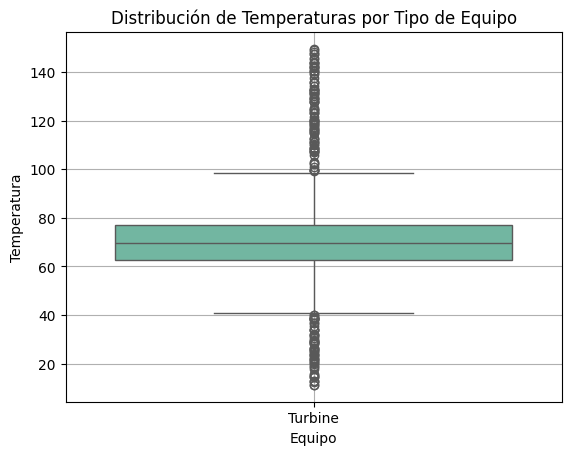

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear boxplot
sns.boxplot(x='equipment', y='temperature', data=df_turbina, palette='Set2')

# Personalización
plt.title('Distribución de Temperaturas por Tipo de Equipo')
plt.xlabel('Equipo')
plt.ylabel('Temperatura')
plt.grid(True)

plt.show()


FILTRADO DE OUTLIERS: RANGO INTERCUARTIL

Para el entrenamiento del modelo, se precisa que el dataset no tenga outliers que puedan interferir en la predicción de las respuestas. Para ello, filtramos los valores outliers con la técnica de rango intercuartil.

In [6]:
#Calcular Q1 y Q3

Q1=df_turbina['temperature'].quantile(0.25)
Q3=df_turbina['temperature'].quantile(0.75)
IQR = Q3 - Q1

limiteinferior = Q1 - 1.5*IQR
limitesuperior = Q3 + 1.5*IQR

#filtrar para que quede sin outliers
sin_outliers = df_turbina[(df_turbina['temperature'] >= limiteinferior) & (df_turbina['temperature'] <= limitesuperior)]

print ("DF sin Outliers:")
print(sin_outliers)



# averiguamos qué porcentaje del total de nuestro dataset NO son outliers
total_datos = len(df_turbina)
total_sinoutliers = len(sin_outliers)

porcentaje_outliers = (total_sinoutliers / total_datos) * 100

print(f"Cantidad de datos filtrados (datos sin outliers): {total_sinoutliers:.2f}")
print(f"Porcentaje de datos sin outliers sobre el total de datos: {porcentaje_outliers:.2f}%")

DF sin Outliers:
      temperature   pressure  vibration   humidity equipment       location  \
0       58.180180  25.029278   0.606516  45.694907   Turbine        Atlanta   
2       71.358594  27.276830   1.389198  58.954409   Turbine  San Francisco   
13      84.711703  44.084965   1.359403  47.560971   Turbine  San Francisco   
14      83.736585  53.447573   1.643008  25.525049   Turbine       New York   
18      68.372071  21.394982   1.224774  47.377719   Turbine        Atlanta   
...           ...        ...        ...        ...       ...            ...   
7654    82.958718  33.590926   0.965781  55.287772   Turbine        Houston   
7658    56.518230  43.456472   0.844428  56.114135   Turbine  San Francisco   
7662    71.396537  27.255896   1.918917  65.060127   Turbine        Houston   
7663    64.259174  32.131660   1.874060  39.069232   Turbine       New York   
7665    62.179965  36.422638   1.565271  51.606218   Turbine        Atlanta   

      faulty  
0        0.0  
2   

### IDENTIFICAR CARACTERÍSTICAS RELEVANTES

Se debe identificar las variables físicas que más impactan en la variable "fualty" (falla/no falla) para luego entrenar el modelo de predicción en base a ellas.

             temperature  pressure  vibration  humidity    faulty
temperature     1.000000  0.007042   0.021701 -0.054190  0.017392
pressure        0.007042  1.000000   0.030267 -0.018260  0.127263
vibration       0.021701  0.030267   1.000000  0.025531  0.345725
humidity       -0.054190 -0.018260   0.025531  1.000000 -0.004729
faulty          0.017392  0.127263   0.345725 -0.004729  1.000000


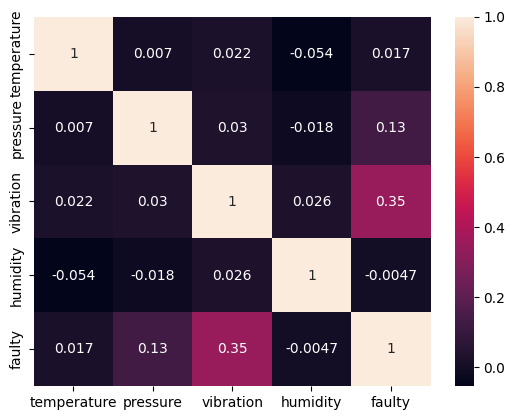

In [7]:
df_sin_equipment= sin_outliers.drop(columns=['equipment' , 'location'])
correlation_matrix= df_sin_equipment.corr()
print(correlation_matrix)
import seaborn as sns
sns.heatmap(correlation_matrix, annot=True)
plt.show()

Como podemos observar en la matriz de confusión las variables que más influyen sobre el campo falla son : vibración, presión y temperatura. Esto también lo validaremos posteriormente con el método f_classifier.

In [8]:
print(df_turbina.columns) # A modo informativo, se detectan las columnas de nuestro dataset de turbina


Index(['temperature', 'pressure', 'vibration', 'humidity', 'equipment',
       'location', 'faulty'],
      dtype='object')


In [9]:
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif

# 1. Definir X (solo columnas numéricas) e y
columnas_numericas = ['temperature', 'pressure', 'vibration', 'humidity']
X_car = df_turbina[columnas_numericas]
y_car = df_turbina['faulty']

# 2. Aplicar SelectKBest con f_classif
k = 3  # Número de características a seleccionar
selector = SelectKBest(score_func=f_classif, k=k)
X_seleccionado = selector.fit_transform(X_car, y_car)

# 3. Obtener nombres de características seleccionadas
caracteristicas_seleccionadas = X_car.columns[selector.get_support()].tolist()

# 4. Mostrar resultados
print("\nCaracterísticas seleccionadas:")
for caracteristica in caracteristicas_seleccionadas:
    print(f"- {caracteristica}")



Características seleccionadas:
- temperature
- pressure
- vibration


Se corrobora que las 3 variables físicas de interés,son las que se mencionaban en la matriz de confusión

### CREACIÓN DEL MODELO DE PREDICCIÓN

Se evaluará si el modelo de predicción de regresión logística o random forest se ajusta mejor. Ambos son modelos de aprendizaje supervisado.

REGRESIÓN LOGÍSTICA

Métricas del modelo de Regresión Logística:
Accuracy       : 0.9474
Precision      : 0.9615
Recall         : 0.4902
F1-score       : 0.6494


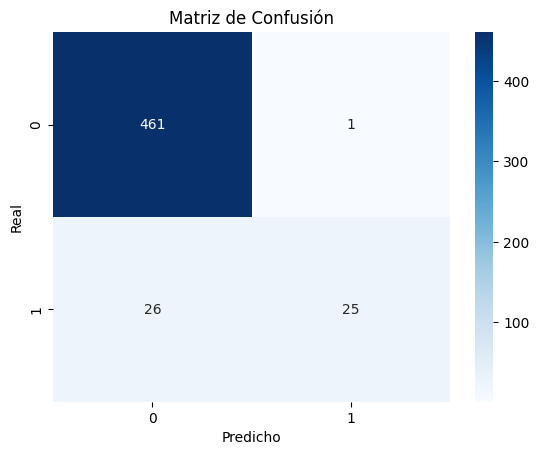

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       462
         1.0       0.96      0.49      0.65        51

    accuracy                           0.95       513
   macro avg       0.95      0.74      0.81       513
weighted avg       0.95      0.95      0.94       513



In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(X_car, y_car, test_size=0.2, random_state=42)

# Entrenar modelo de regresión logística
modelo = LogisticRegression(max_iter=1000)
modelo.fit(X_train, y_train)

# Predecir
y_pred = modelo.predict(X_test)

# Calcular métricas
print("Métricas del modelo de Regresión Logística:")
print(f"Accuracy       : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision      : {precision_score(y_test, y_pred):.4f}")
print(f"Recall         : {recall_score(y_test, y_pred):.4f}")
print(f"F1-score       : {f1_score(y_test, y_pred):.4f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

# Reporte completo
print("Classification Report:")
print(classification_report(y_test, y_pred))


RANDOM FOREST

Métricas para Random Forest:
Accuracy : 0.9786
Precision: 0.9167
Recall   : 0.8627
F1-score : 0.8889


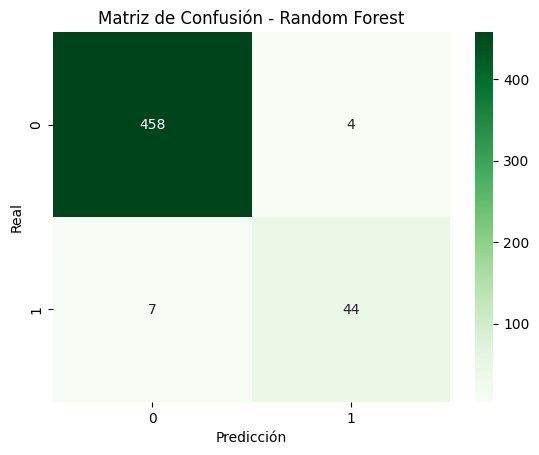

Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       462
         1.0       0.92      0.86      0.89        51

    accuracy                           0.98       513
   macro avg       0.95      0.93      0.94       513
weighted avg       0.98      0.98      0.98       513



In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_car, y_car, test_size=0.2, random_state=42)

# Entrenar Random Forest
modelo = RandomForestClassifier(random_state=42)
modelo.fit(X_train, y_train)

# Predecir
y_pred = modelo.predict(X_test)

# Métricas
print("Métricas para Random Forest:")
print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred):.4f}")
print(f"F1-score : {f1_score(y_test, y_pred):.4f}")

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Matriz de Confusión - Random Forest")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# Reporte completo
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))

RESUMEN COMPARANDO AMBOS MÉTODOS

El modelo de random forest es el que mejor se adapta a nuestra dataset. Tiene un Accuracy de 0.98 contra 0.95 de regresión logística.

| Métrica                 | Qué mide?                                                     |  Random Forest          |   Regresión Logística  |   
| ----------------------- | ------------------------------------------------------------- |------------------------ |------------------------|
| **Accuracy**            | Proporción de predicciones correctas                          |  0.9786                   |    0.9474                    |   
| **Precision**           | ¿Qué tan confiable es el modelo cuando dice “positivo”? |  0.9167              | 0.9615                        |   
| **Recall**              | ¿Qué tan bien encuentra el modelo los positivos reales?                  |  0.8627              |   0.4902                     |   
| **F1-score**            | Balance entre precisión y recall                              |  0.8889              |   0.6494                     |   


## DATA SCIENCE 2 INCLUSIÓN DE API

In [12]:
df_turbina2 = df[df['equipment'] == 'Turbine']
df_turbina2.describe()
conteo_dfturbina2 = df_turbina2.groupby('location').size().reset_index(name='Cantidad')
print(conteo_dfturbina2)
print(df_turbina2.head())

        location  Cantidad
0        Atlanta       540
1        Chicago       501
2        Houston       527
3       New York       498
4  San Francisco       499
    temperature   pressure  vibration   humidity equipment       location  \
0     58.180180  25.029278   0.606516  45.694907   Turbine        Atlanta   
2     71.358594  27.276830   1.389198  58.954409   Turbine  San Francisco   
7    148.923369  22.214121   0.109819  39.944953   Turbine  San Francisco   
13    84.711703  44.084965   1.359403  47.560971   Turbine  San Francisco   
14    83.736585  53.447573   1.643008  25.525049   Turbine       New York   

    faulty  
0      0.0  
2      0.0  
7      1.0  
13     0.0  
14     0.0  


In [13]:
df_turbina_atlanta = df[(df['equipment'] == 'Turbine') & (df['location'] == 'Atlanta')]
print(df_turbina_atlanta .head())

conteo_dfturbina_atlanta = df_turbina_atlanta.groupby('faulty').size().reset_index(name='Cantidad')
print(conteo_dfturbina_atlanta)

    temperature   pressure  vibration   humidity equipment location  faulty
0     58.180180  25.029278   0.606516  45.694907   Turbine  Atlanta     0.0
18    68.372071  21.394982   1.224774  47.377719   Turbine  Atlanta     0.0
44    69.016902  53.664284   1.380225  70.495073   Turbine  Atlanta     0.0
49    83.641404  25.740674   1.257435  42.644693   Turbine  Atlanta     0.0
51    61.255644  32.126947   1.987554  58.671531   Turbine  Atlanta     0.0
   faulty  Cantidad
0     0.0       486
1     1.0        54


In [2]:
import openmeteo_requests
import pandas as pd
from datetime import datetime, timedelta

# Crear cliente
openmeteo = openmeteo_requests.Client()

# Parámetros de la API
url = "https://api.open-meteo.com/v1/forecast"
params = {
    "latitude": 33.7490,
    "longitude": -84.3880,
    "hourly": ["temperature_2m"],
    "start_date": "2025-09-01",
    "end_date": "2025-09-30",
    "timezone": "America/New_York"
}

# Llamada a la API
responses = openmeteo.weather_api(url, params=params)
response = responses[0]

# Extraer datos horarios correctamente
hourly = response.Hourly()

# Extraer valores de temperatura
temperaturas = hourly.Variables(0).ValuesAsNumpy()

# Generar las fechas y horas
start_time = datetime.fromtimestamp(response.Hourly().Time(), tz=None)
interval = hourly.Interval()  # generalmente 3600 segundos (1 hora)
fechas = [start_time + timedelta(seconds=i * interval) for i in range(len(temperaturas))]

# Crear DataFrame
df_temp = pd.DataFrame({
    "Fecha_Hora": fechas,
    "Temperatura_2m": temperaturas
})

print(df_temp.head())
print(f"\nTotal de registros: {len(df_temp)}")

# (Opcional) Guardar CSV
# df_temp.to_csv("temperaturas_atlanta_sep2026.csv", index=False)


           Fecha_Hora  Temperatura_2m
0 2025-09-01 01:00:00       21.752501
1 2025-09-01 02:00:00       21.452499
2 2025-09-01 03:00:00       21.102501
3 2025-09-01 04:00:00       20.652500
4 2025-09-01 05:00:00       20.202499

Total de registros: 720
